# Lab 7: Q-learning

## Proof from Lab 6 - Contraction of Bellman Operator


We need to define some things first. Let's have an MDP with:
- states $\mathcal S = \{s_1, s_2, ..., s_n\}$
- actions $\mathcal A = \{a_1, a_2, ..., a_m\}$
- expected reward $\mathcal R^a_s$ in state $s$ when taking action $a$
- probability $\mathcal P^a_{s,s'}$ of transition $s \xrightarrow{a} s'$
- a discount factor $\gamma \in [0, 1)$

Let $\pi(a|s)$ denote the probability of taking action $a$ in state $s$ under policy $\pi$.

Let's define some more useful quantities. An expected reward under policy $\pi$ is:
$$ \mathbf{R}_\pi(s) = \sum_{a \in \mathcal A} \pi(a|s) \mathcal R^a_s $$

And the probability of transition under policy $\pi$ is:
$$ \mathbf{P}_\pi(s, s') = \sum_{a \in \mathcal A} \pi(a|s) \mathcal P^a_{s, s'} $$

A value function is $v: \mathcal S \rightarrow \mathbb R$.

For the ease of notation, let's view $v$ as a vector of values $[v(s_1), v(s_2), ..., v(s_n)]$. Similarly, let's overload $\mathbf R_\pi = [\mathbf R_\pi(s_1), \mathbf R_\pi(s_2), ..., \mathbf R_\pi(s_n)]$ and $\mathbf P_\pi$ as a matrix $\mathbf P_\pi = [\mathbf P_\pi(s_i, s_j)]; i,j \in \{1..n\}$.

A value function for a policy $\pi$ satisfies $v_\pi = \mathbf R_\pi +  \gamma \mathbf P_\pi v_\pi$.

<!-- An optimal value function $v_*(s) = \max_{\pi} v_\pi(s), \forall s$ satisfies $v_*(s) = \mathbf R_\pi(s) + \gamma \max_a v_*(s')$ -->

Let $\mathbf B_\pi$ be a *Bellman policy operator*: $\mathbf B_\pi v = \mathbf R_\pi + \gamma \mathbf P_\pi v$.

Let $||\mathbf x||_\infty = \max(x_1, x_2, ...)$ be a *max* norm.


**Task:** Prove that $\mathbf B_\pi$ is a contraction under *max* norm, i.e. $|| \mathbf B_\pi v_1 - \mathbf B_\pi v_2||_\infty \leq \gamma || v_1 - v_2 ||_\infty$ for any $v_1, v_2$.

*Proof.*

$$\begin{align}
|| \mathbf B_\pi v_1 - \mathbf B_\pi v_2 ||_\infty
  & = || \mathbf R_\pi + \gamma \mathbf P_\pi v_1 - \mathbf R_\pi - \gamma \mathbf P_\pi v_2||_\infty \\
  & = ||  \gamma \mathbf P_\pi v_1 - \gamma \mathbf P_\pi v_2||_\infty \\
  & = \gamma|| \mathbf P_\pi (v_1 -  v_2) ||_\infty \\
  & \leq \gamma|| v_1 -  v_2 ||_\infty \\
\end{align}$$

The last step follows from the fact that if $\mathbf A$ is a non-negative matrix and all $\sum_{j} \mathbf A_{ij} = 1; \forall i$ (all rows sum to one), then
$$\max \mathbf Ax \leq \max x $$
Each element of the resulting vector $x' = \mathbf Ax $ is a convex combination of $x$ which can only be lesser or equal than the max element in $x$, i.e.: $x'_i \leq \max x; \forall i$.

## Frozen Lake

As in the previous case, we will use the familiar Frozen Lake environment.

To remind you what it is: It's a grid-world with a goal and a chance that some movements will slip and perform a random action. You cannot enter the wall and there are dangerous pits that terminate the episode with a large penalty.

In this lab, we will focus on Q-learning, which is a *off-policy* *model-free* algorithm.

**Question:** What is a off-policy algorithm?


**Question:** What is a model-free algorithm?



Let's update the FrozenLake to be a simulator - it will remember the position of the player and can sample the actions. The key methods are `reset()` and `step()`.

In [ ]:
import numpy as np, random
import matplotlib.pyplot as plt
from typing import List, Tuple

#set random seed.
random.seed(0)
np.random.seed(0)

example_map =  ["#########",
                "#       #",
                "#       #",
                "# ooooo #",
                "#   #  G#",
                "#########"]

# # = wall
# G = goal
# o = pit

Action = str # Action corresponds to a movement ['^', 'v', '<', '>'].
State = Tuple[int, int]  # State corresponds to a coordinate in the map.

class FrozenLakeEnv():
  ILLEGAL  = {"#"}
  TERMINAL = {"o", "G", "#"}
  REWARDS  = {
    "#": -0.1,
    " ": -0.1,
    "G":  1,
    "o": -10
    }
  MOVE_DIFFS = {
    '^': [-1,  0], # Move up.
    '<': [ 0, -1], # Move down.
    '>': [ 0,  1], # Move left.
    'v': [ 1,  0], # Move right.
    }

  def __init__(self, map: List[str], slip_probability: float):
    self.map = np.array([list(row) for row in map])
    self.init_state = np.where( self.map == "@" )   # find the player
    self.map[ self.init_state ] = " "               # remove the player

    self.slip_probability = slip_probability
    self.log_off()

  def reset(self):
    self.state = np.array( [self.init_state[0][0], self.init_state[1][0]] )
    self.terminated = False

    return self.state

  def actions(self) -> List[Action]:
    ''' Return all possible actions '''
    return list(self.MOVE_DIFFS.keys())


  def step(self, action: Action) -> Tuple[State, float, bool]:
    assert not self.terminated

    if np.random.rand() > self.slip_probability:
      s_ = self.state + self.MOVE_DIFFS[action]

    else:
      random_action = random.choice( self.actions() )
      s_ = self.state + self.MOVE_DIFFS[random_action]

    if self.map[s_[0], s_[1]] in self.ILLEGAL:
      s_ = self.state

    reward = self.REWARDS[ self.map[s_[0], s_[1]] ]
    done = self.map[s_[0], s_[1]] in self.TERMINAL

    if self.log:
      print(f"{self.state} + {action} => {s_}, r: {reward}, done: {done}")

    self.state = s_
    self.terminated = done

    return s_, reward, done

  def log_on(self):
    self.log = True

  def log_off(self):
    self.log = False

  def __str__(self):
    self.map_repr = self.map.copy()
    self.map_repr[self.state[0], self.state[1]] = "@"

    return "\n".join(["".join(row) for row in self.map_repr])

  def __repr__(self):
    return str(self)

In [ ]:
map = ["#########",
       "#       #",
       "#       #",
       "# ooooo #",
       "#@  #  G#",
       "#########"]

lake = FrozenLakeEnv(map, slip_probability=0.1)
lake.reset()
lake

## Q-learning

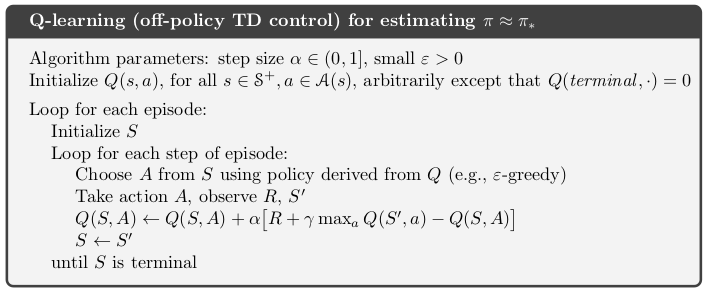

Since the states are positions in the maze, we will represent the Q function as a three dimensional array - a two-dimensional array for each action.

Below, implement an e-greedy policy and Q-learning.

In [ ]:
plt.rcParams['figure.figsize'] = [16, 10]

# Auxiliary method to plot the values. You can skip this.
def plot_q(q: np.array):
  fig, axs = plt.subplots(1, 4)

  actions = list(FrozenLakeEnv.MOVE_DIFFS.keys())

  for a, a_label in enumerate(actions):
    qa = q[a]
    ax = axs[a]
    ax.set_title(f"Action {a_label}")

    im = ax.imshow(qa, vmin=-2., vmax=1.)

    # Loop over data dimensions and create text annotations.
    for i in range(qa.shape[0]):
      for j in range(qa.shape[1]):
        text = ax.text(j, i, f"{qa[i, j]:.2f}", ha="center", va="center", color="w")

  plt.tight_layout()
  plt.show()

In [ ]:
class EpsilonGreedyPolicy():
  def __init__(self, epsilon):
    self.epsilon = epsilon

  def act(self, q, s):
    # Task:
    # - implement epsilon-greedy policy wrt. current q-function
    # - the correct indexing to q is q[action, s[0], s[1]]
    # - you can use numpy's slicing; e.g., like this arr[:, 0]
    #raise NotImplementedError

class QLearning():
  def __init__(self, env, exploration_policy, alpha, gamma):
    self.env = env
    self.exploration_policy = exploration_policy
    self.alpha_init = alpha
    self.gamma = gamma

    self.episode = 1
    self.q = np.zeros( (len(env.actions()), env.map.shape[0], env.map.shape[1]) )

  def get_alpha(self):
    return self.alpha_init

  def run(self, episodes, log_each=1):
    for episode in range(self.episode, self.episode + episodes):
      if episode % log_each == 0:
        print(f"Episode {episode}:")

      self.q = self.q_learning_single_episode(self.q)

      if episode % log_each == 0:
        plot_q(self.q)

      self.episode += 1

  def q_learning_single_episode(self, q):
    # Task:
    # - implement q-learning
    # - call self.get_alpha() to get the learning rate

    return q

Okay, let's try it!

In [ ]:
pi = EpsilonGreedyPolicy(0.1)
qlearning = QLearning(lake, pi, alpha=0.1, gamma=0.9)

lake.log_on()
qlearning.run(episodes=5)

Well, we can already say it's *extremely* sample-inefficient. We've run the algorithm for 5 full episodes, and it's still nowhere near convergence.

**Question:** Look at the episode 0, and the agent trajectory and explain the new values in the Q function.


If we plot the graphs after each episode we would be here for a *very* long time. Let's speed it up a bit.

In [ ]:
lake.log_off()
qlearning.run(episodes=500, log_each=100)

Finally, some action! It seems that the agent found the gold at least in some trajectories. But the values look weird. It seems that they are not converging.

**Question:** Look at [3,7], right above the gold. Why is the value sometimes large and sometimes low?



The fundamental reason for the weird behaviour is because the convergence of Q learning is assured only under some conditions. They are:

- all states are visited infinitely often
- $\sum_{t} \alpha_t = \infty$
- $\sum_{t} \alpha_t^2 < \infty$

where $\alpha_t$ is the learning rate at step $t$.

**Question:** The first condition is already satisfied (asymptotically). Why?


However, the third condition is not met. We need to *anneal* the learning rate towards zero, while satisfying the second condition. Such annealing schedule is $\alpha_t = \min(\alpha_0, \frac{ \alpha_0}{k t})$, with some constant $k$. Let's implement it.

In [ ]:
class QLearningAnnealed(QLearning):
  def __init__(self, problem, exploration_policy, k, alpha, gamma):
    super().__init__(problem, exploration_policy, alpha, gamma)
    self.k = k

  def get_alpha(self):
    # Task: use self.alpha_init, self.episode and self.k
    raise NotImplementedError


In [ ]:
pi = EpsilonGreedyPolicy(0.1)
qlearning = QLearningAnnealed(lake, pi, k=0.1, alpha=0.1, gamma=0.9)

qlearning.run(episodes=1000, log_each=100)

Okay, that seems like a good result!

**Question:** The $k$ is called a *hyperparameter*. We used $k=0.1$ why?


**Question:** Did we use any other hyperparameters?


**Question:** Given the Q values we just computed, how would we extract the value function? For reference, see the optimal value function (computed in the last lab) below.




*Optimal value:*

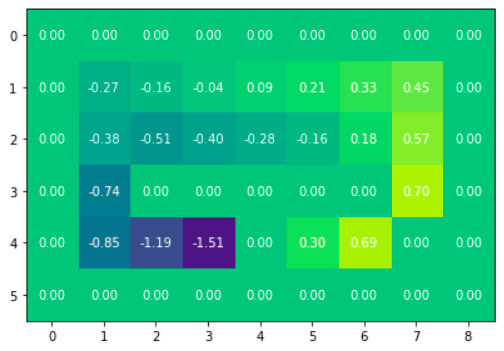

**Question:** If you compare the computed Q values with the optimal V values above, the Q values for [4, 5] and [4, 6] are missing (are 0). Why?



**Question:** Last time, when computing the value function with value iteration, we needed an expected return over all actions. Where did it go? Why don't we need it now?


**Bonus question:** In the q-learning algorithm, the values are updated only from the adjancent states. Hence, the rewards propagate rather slowly through the state space. Can you think about a way to speed it up?



## Task 2 - Stochastic BlockWorld and Q-learning

See https://cw.fel.cvut.cz/wiki/courses/zui/tasks/task2.

Task hints:
- think about what is a state
- make sure that $Q(s, \cdot) = 0$ if $s$ is terminal
- you have to tune the hyperparameters
- make sure your method is robust, i.e., it performs well even when run repeatedly
- all you learned in this Lab should be enough to solve the task; you can't represent the Q function as a matrix though - what is a proper representation?



## (Optional) Task 3 - On-Policy Rinforcement Learning




**Question:** What is policy?



On-Policy Learning:

On-policy reinforcement learning is a category of reinforcement learning algorithms where the policy being learned about and the policy used to make decisions are the same. This means that the agent learns from the actions it takes, rather than learning from actions it might have taken under a different policy. This approach ensures that the policy is evaluated and improved based on the experiences gathered by following it, leading to a direct feedback loop for policy enhancement.

Off-Policy Learning:

Off-policy reinforcement learning refers to a category of reinforcement learning algorithms where the policy being improved, known as the target policy, is different from the policy used to generate behavior, known as the behavior policy. This distinction allows the agent to learn from experiences gathered by exploring the environment using a potentially different policy than the one it aims to optimize. This approach provides the flexibility to learn about the optimal policy while following a more explorative or different policy for action selection.

**Question:** Is Q-Learning a on-policy or off-policy?



## SARSA  (State-Action-Reward-State-Action)

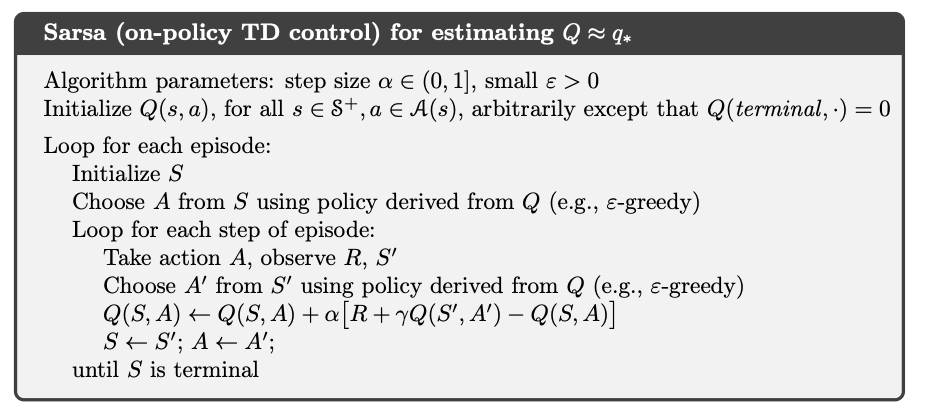

SARSA stands for State-Action-Reward-State-Action, and it is an on-policy reinforcement learning algorithm. This means that the policy the agent is currently following is the same policy that is being evaluated and improved. The acronym SARSA reflects the data used to update the value of a policy: the current state (S), the action (A) taken in that state, the reward (R) received after taking that action, the new state (S') arrived at after taking that action, and finally the next action (A') taken in the new state.

**Question:** What is the difference between SARSA and Q-Learning?



In [ ]:
class SARSA():
    def __init__(self, env, exploration_policy, k, alpha, gamma):
        self.env = env
        self.exploration_policy = exploration_policy
        self.alpha_init = alpha
        self.gamma = gamma
        self.k = k

        self.episode = 1
        self.q = np.zeros((len(env.actions()), env.map.shape[0], env.map.shape[1]))

    def get_alpha(self):
        return min( self.alpha_init, self.alpha_init / (self.k * self.episode) )

    def run(self, episodes, log_each=1):
        for episode in range(self.episode, self.episode + episodes):
            if episode % log_each == 0:
                print(f"Episode {episode}:")

            self.q = self.sarsa_single_episode(self.q)

            if episode % log_each == 0:
                plot_q(self.q)  # Ensure this function is defined elsewhere

            self.episode += 1

    def sarsa_single_episode(self, q):
        # Task:
        # - implement sarsa
        # - call self.get_alpha() to get the learning rate

        return q

In [ ]:
pi = EpsilonGreedyPolicy(0.1)
sarsa = SARSA(lake, pi, k=0.1, alpha=0.1, gamma=0.9)

lake.log_off()
sarsa.run(episodes=500, log_each=100)

Let's increase the fronze lake size and run both Q-Learning and SARSA on the new map.

In [ ]:
map = ["#########",
       "#       #",
       "#       #",
       "#       #",
       "# ooooo #",
       "#@  #  G#",
       "#########"]

lake = FrozenLakeEnv(map, slip_probability=0.1)
lake.reset()
lake

In [ ]:
pi = EpsilonGreedyPolicy(0.1)
qlearning = QLearningAnnealed(lake, pi, k=0.1, alpha=0.1, gamma=0.9)

lake.log_off()
qlearning.run(episodes=500, log_each=100)

In [ ]:
pi = EpsilonGreedyPolicy(0.1)
sarsa = SARSA(lake, pi, k=0.2, alpha=0.1, gamma=0.9)

lake.log_off()
sarsa.run(episodes=1000, log_each=100)

**Question:** What's the difference between the policies learned from Q-Learning and SARSA?

